# 라이브러리 불러오기

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import torchvision.utils
from PIL import Image

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 데이터셋 가져오기

In [19]:
# 데이터 전처리 코드
# 정규화
transform = transforms.Compose([
    transforms.ToTensor(), # 이미지 행렬을 Pytorch에 맞는형변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 평균, 표준편차 ==> RGB 채널별 정규화
])
# 훈련 데이터
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [20]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64, # 배치 크기
    shuffle=True,  # 데이터 섞기
    num_workers=2  # 데이터 로딩에 사용할 프로세스 수
)

In [21]:
# 테스트 데이터
testset = torchvision.datasets.CIFAR10(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transform)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64, # 배치 크기
    shuffle=False,  # 데이터 섞기
    num_workers=2  # 데이터 로딩에 사용할 프로세스 수
)

# 데이터 시각화

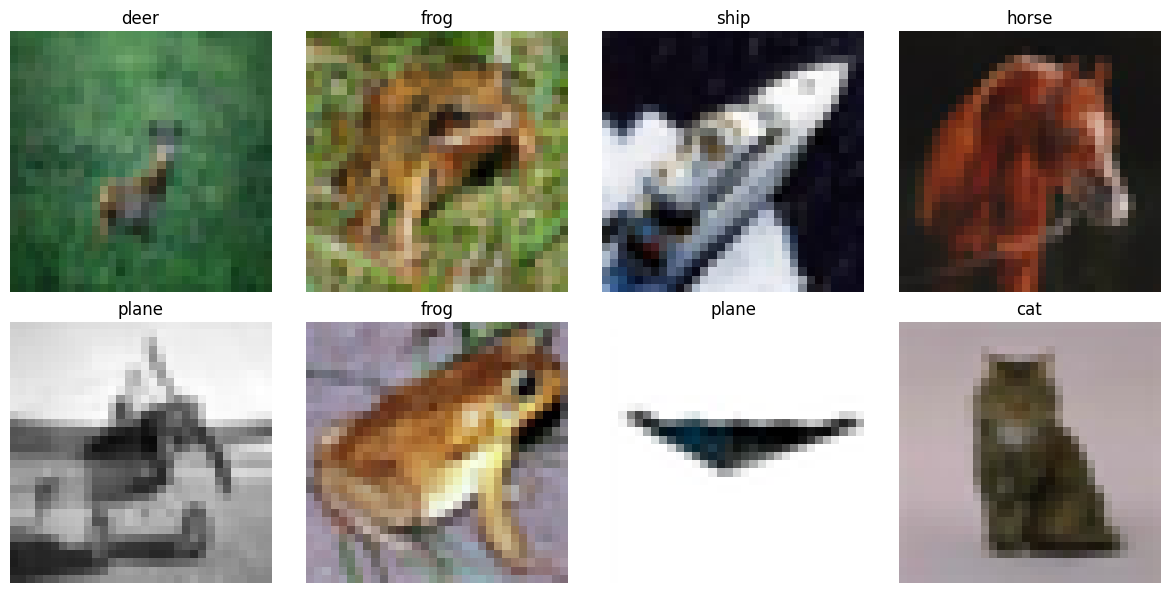

이미지 크기: torch.Size([3, 32, 32])
배치 크기: 64
채널 수: 3
이미지 높이: 32
이미지 너비: 32


In [22]:
import matplotlib.pyplot as plt 
import numpy as np

# 클래스 이름 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 학습 데이터의 일부 이미지 시각화
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 그리드 생성
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    imshow(images[i])
    axes[i].imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 이미지 통계 정보 출력
print(f"이미지 크기: {images[0].shape}")
print(f"배치 크기: {images.size(0)}")
print(f"채널 수: {images.size(1)}")
print(f"이미지 높이: {images.size(2)}")
print(f"이미지 너비: {images.size(3)}")

# 모델 만들기

In [23]:
classes = trainset.classes # 클래스 이름 저장
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [34]:
# CNN 모델 
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 첫번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(
            # 이미지와 관련된 옵션
            in_channels=3,     # RGB 3채널 (이미지와 관련된 기본 상식)
            out_channels=32,  # 32개의 필터 (CNN 이론)
            kernel_size=3,     # 3x3 커널 (CNN 이론)
            padding=1          # 패딩으로 크기 유지 (CNN 이론)
        )
        self.pool = nn.MaxPool2d(2, 2) # 2 x 2 최대 풀링 (CNN 이론)

        # 두번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(
            # 이미지와 관련된 옵션
            in_channels=32,     # 1번째 레이어의 out_channel이 32
            out_channels=64,  # 64개의 필터 (CNN 이론)
            kernel_size=3,     # 3x3 커널 (CNN 이론)
            padding=1          # 패딩으로 크기 유지 (CNN 이론)
        )

        # 완전 연결 레이어, 정형 데이터 분류 모형 알고리즘과 똑같음
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # 128개의 뉴런으로 만들겠음
        self.fc2 = nn.Linear(128, 10)          # 10개의 클래스로 출력

    def forward(self, x):
        # 첫번쩨 컨볼루션 블록
        x = self.pool(F.relu(self.conv1(x))) # Conv => Relu => Pool
        
        # 두번재 컨볼루션 블록
        x = self.pool(F.relu(self.conv2(x))) # Conv => Relu => Pool

        # Flatten 및 완전 연결 레이어
        x = x.view(-1, 64 * 8 * 8)     # 2차원과 관련된 데이터를 1차원으로 변환
        x = F.relu(self.fc1(x))        # 첫번째 FC + Relu
        x = self.fc2(x)                # 최종 출력
        return x

# 모델 초기화

In [35]:
# 모델 초기화 및 학습 설정
model = SimpleCNN().to(device)  # 모델을 GPU로 이동
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 옵티마이저

## 모델 학습

In [37]:
for epoch in range(1): # 1 에포크 학습
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        # 데이터를 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)

        # 순전파 및 역전파
        optimizer.zero_grad() # 그래디언트 초기화
        outputs = model(inputs) # 순전파
        loss = criterion(outputs, labels) # 손실계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        # 손실 기록 및 출력
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("학습 완료 ✅")

[1,   100] loss: 1.823
[1,   200] loss: 1.502
[1,   300] loss: 1.397
[1,   400] loss: 1.299
[1,   500] loss: 1.239
[1,   600] loss: 1.165
[1,   700] loss: 1.130
학습 완료 ✅


# 모델 평가

In [40]:
model.eval() # 평가 모드로 전횐
correct = 0
total = 0
with torch.no_grad(): # 그래디언트 계산 비활성화
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # 가장 높은 확률의 클래스 선택
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct / total)

0.6222


# 모델 저장

In [41]:
torch.save(model.state_dict(), "cifar10_cnn_0605.pth")
print("모델 저장 완료")

모델 저장 완료


# Efficient Net

In [43]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm  # EfficientNet 모델을 위한 라이브러리
from tqdm import tqdm  # 진행률 표시를 위한 라이브러리

# GPU 사용 가능 여부 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 이미지 전처리를 위한 변환 파이프라인 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet 모델의 입력 크기로 조정
    transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
    transforms.Normalize(  # ImageNet 데이터셋의 평균과 표준편차로 정규화
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# CIFAR-10 훈련 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(
    root='./data',  # 데이터 저장 경로
    train=True,     # 훈련 데이터 사용
    download=True,  # 데이터가 없으면 다운로드
    transform=transform  # 위에서 정의한 전처리 적용
)
trainloader = DataLoader(
    trainset, 
    batch_size=32,    # 배치 크기
    shuffle=True,     # 데이터 셔플링
    num_workers=2     # 데이터 로딩을 위한 워커 수
)

# CIFAR-10 테스트 데이터셋 로드
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,     # 테스트 데이터 사용
    download=True,
    transform=transform
)
testloader = DataLoader(
    testset,
    batch_size=32,
    shuffle=False,   # 테스트는 셔플링 불필요
    num_workers=2
)

# EfficientNet-B0 모델 로드 (사전 훈련된 가중치 사용)
model = timm.create_model('efficientnet_b0', pretrained=True)

# 마지막 분류 레이어를 CIFAR-10의 10개 클래스에 맞게 수정
model.classifier = nn.Linear(model.classifier.in_features, 10)
model = model.to(device)  # 모델을 GPU로 이동

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# 모델 학습
num_epochs = 5  # 전체 데이터셋을 5번 반복
for epoch in range(num_epochs):
    model.train()  # 학습 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0
    
    # tqdm을 사용하여 진행률 표시
    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)  # 데이터를 GPU로 이동
        
        # 역전파를 위한 그래디언트 초기화
        optimizer.zero_grad()
        # 순전파
        outputs = model(inputs)
        # 손실 계산
        loss = criterion(outputs, labels)
        # 역전파
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        
        # 통계 계산
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 진행률 표시 업데이트
        pbar.set_postfix({
            'loss': running_loss/total, 
            'acc': 100.*correct/total
        })
    
    # 에포크별 결과 출력
    print(f'Epoch {epoch+1} - Loss: {running_loss/len(trainloader):.4f}, '
          f'Accuracy: {100.*correct/total:.2f}%')

# 모델 평가
model.eval()  # 평가 모드로 설정
correct = 0
total = 0
with torch.no_grad():  # 그래디언트 계산 비활성화
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

# 테스트 정확도 출력
print(f'Test Accuracy: {100.*correct/total:.2f}%')

# 학습된 모델 저장
torch.save(model.state_dict(), 'efficientnet_cifar10.pth')
print("모델이 efficientnet_cifar10.pth로 저장되었습니다.")

C:\Users\Admin\Desktop\lgu6_ml_dl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


C:\Users\Admin\Desktop\lgu6_ml_dl\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Epoch 1/5: 100%|█████| 1563/1563 [03:04<00:00,  8.46it/s, loss=0.013, acc=86.2]


Epoch 1 - Loss: 0.4166, Accuracy: 86.16%


Epoch 2/5: 100%|███| 1563/1563 [03:07<00:00,  8.32it/s, loss=0.00756, acc=91.9]


Epoch 2 - Loss: 0.2419, Accuracy: 91.92%


Epoch 3/5: 100%|███| 1563/1563 [03:09<00:00,  8.23it/s, loss=0.00585, acc=93.6]


Epoch 3 - Loss: 0.1871, Accuracy: 93.64%


Epoch 4/5: 100%|███| 1563/1563 [03:11<00:00,  8.18it/s, loss=0.00486, acc=94.8]


Epoch 4 - Loss: 0.1556, Accuracy: 94.77%


Epoch 5/5: 100%|███| 1563/1563 [03:11<00:00,  8.17it/s, loss=0.00408, acc=95.5]


Epoch 5 - Loss: 0.1305, Accuracy: 95.48%
Test Accuracy: 92.67%
모델이 efficientnet_cifar10.pth로 저장되었습니다.
